In [24]:
import sys
sys.path.append("..")

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.manifold import SpectralEmbedding, TSNE, MDS
import torch
import umap
from sklearn.preprocessing import StandardScaler
import hdbscan
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans


In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
if device.type == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))

Using device: cuda
GPU: NVIDIA GeForce RTX 3050 4GB Laptop GPU


## Read data

In [26]:
df = pd.read_csv("extracted_flame_front_10.csv")

# Select meaningful physical variables
#features = ['v', 'T', 'u', 'dudx', 'dudy', 'dvdx', 'dvdy', 'H2',
#       'O2', 'H2O', 'H', 'O', 'OH', 'HO2', 'H2O2' ]
# features = ['u', 'v', 'T', 'dudx', 'dudy', 'dvdx', 'dvdy', 'H2',
#        'O2', 'H2O', 'H', 'O', 'OH', 'HO2', 'H2O2', 'N2', 'heat_release',
#        'curvature', 'stretch_rate', 'disp_speed_density_weighted',
#        'abs_flame_prop_vel_normal', 'flow_velocity_normal',
#        'flow_velocity_tangential', 'tangential_strain_rate',
#        'normal_strain_rate', 'total_strain_rate', 'density_ratio_sigma',
#        'vorticity', 'omega_H2', 'omega_O2', 'omega_H2O', 'omega_H', 'omega_O',
#        'omega_OH', 'omega_HO2', 'omega_H2O2', 'omega_N2', 'Le_def']
# features = [
#     'omega_H2', 'omega_O2', 'omega_H2O', 'omega_H', 'omega_O', 'omega_OH',
#     'omega_HO2', 'omega_H2O2', 'omega_N2'
# ]
features = [ 'H2','O2', 'H2O', 'H', 'O', 'OH', 'HO2', 'H2O2', 'N2']
#df = df[(df['y'] >100) & (df['y'] < 150)]
colourmap = df["disp_speed_density_weighted"]
X = StandardScaler().fit_transform(df[features])


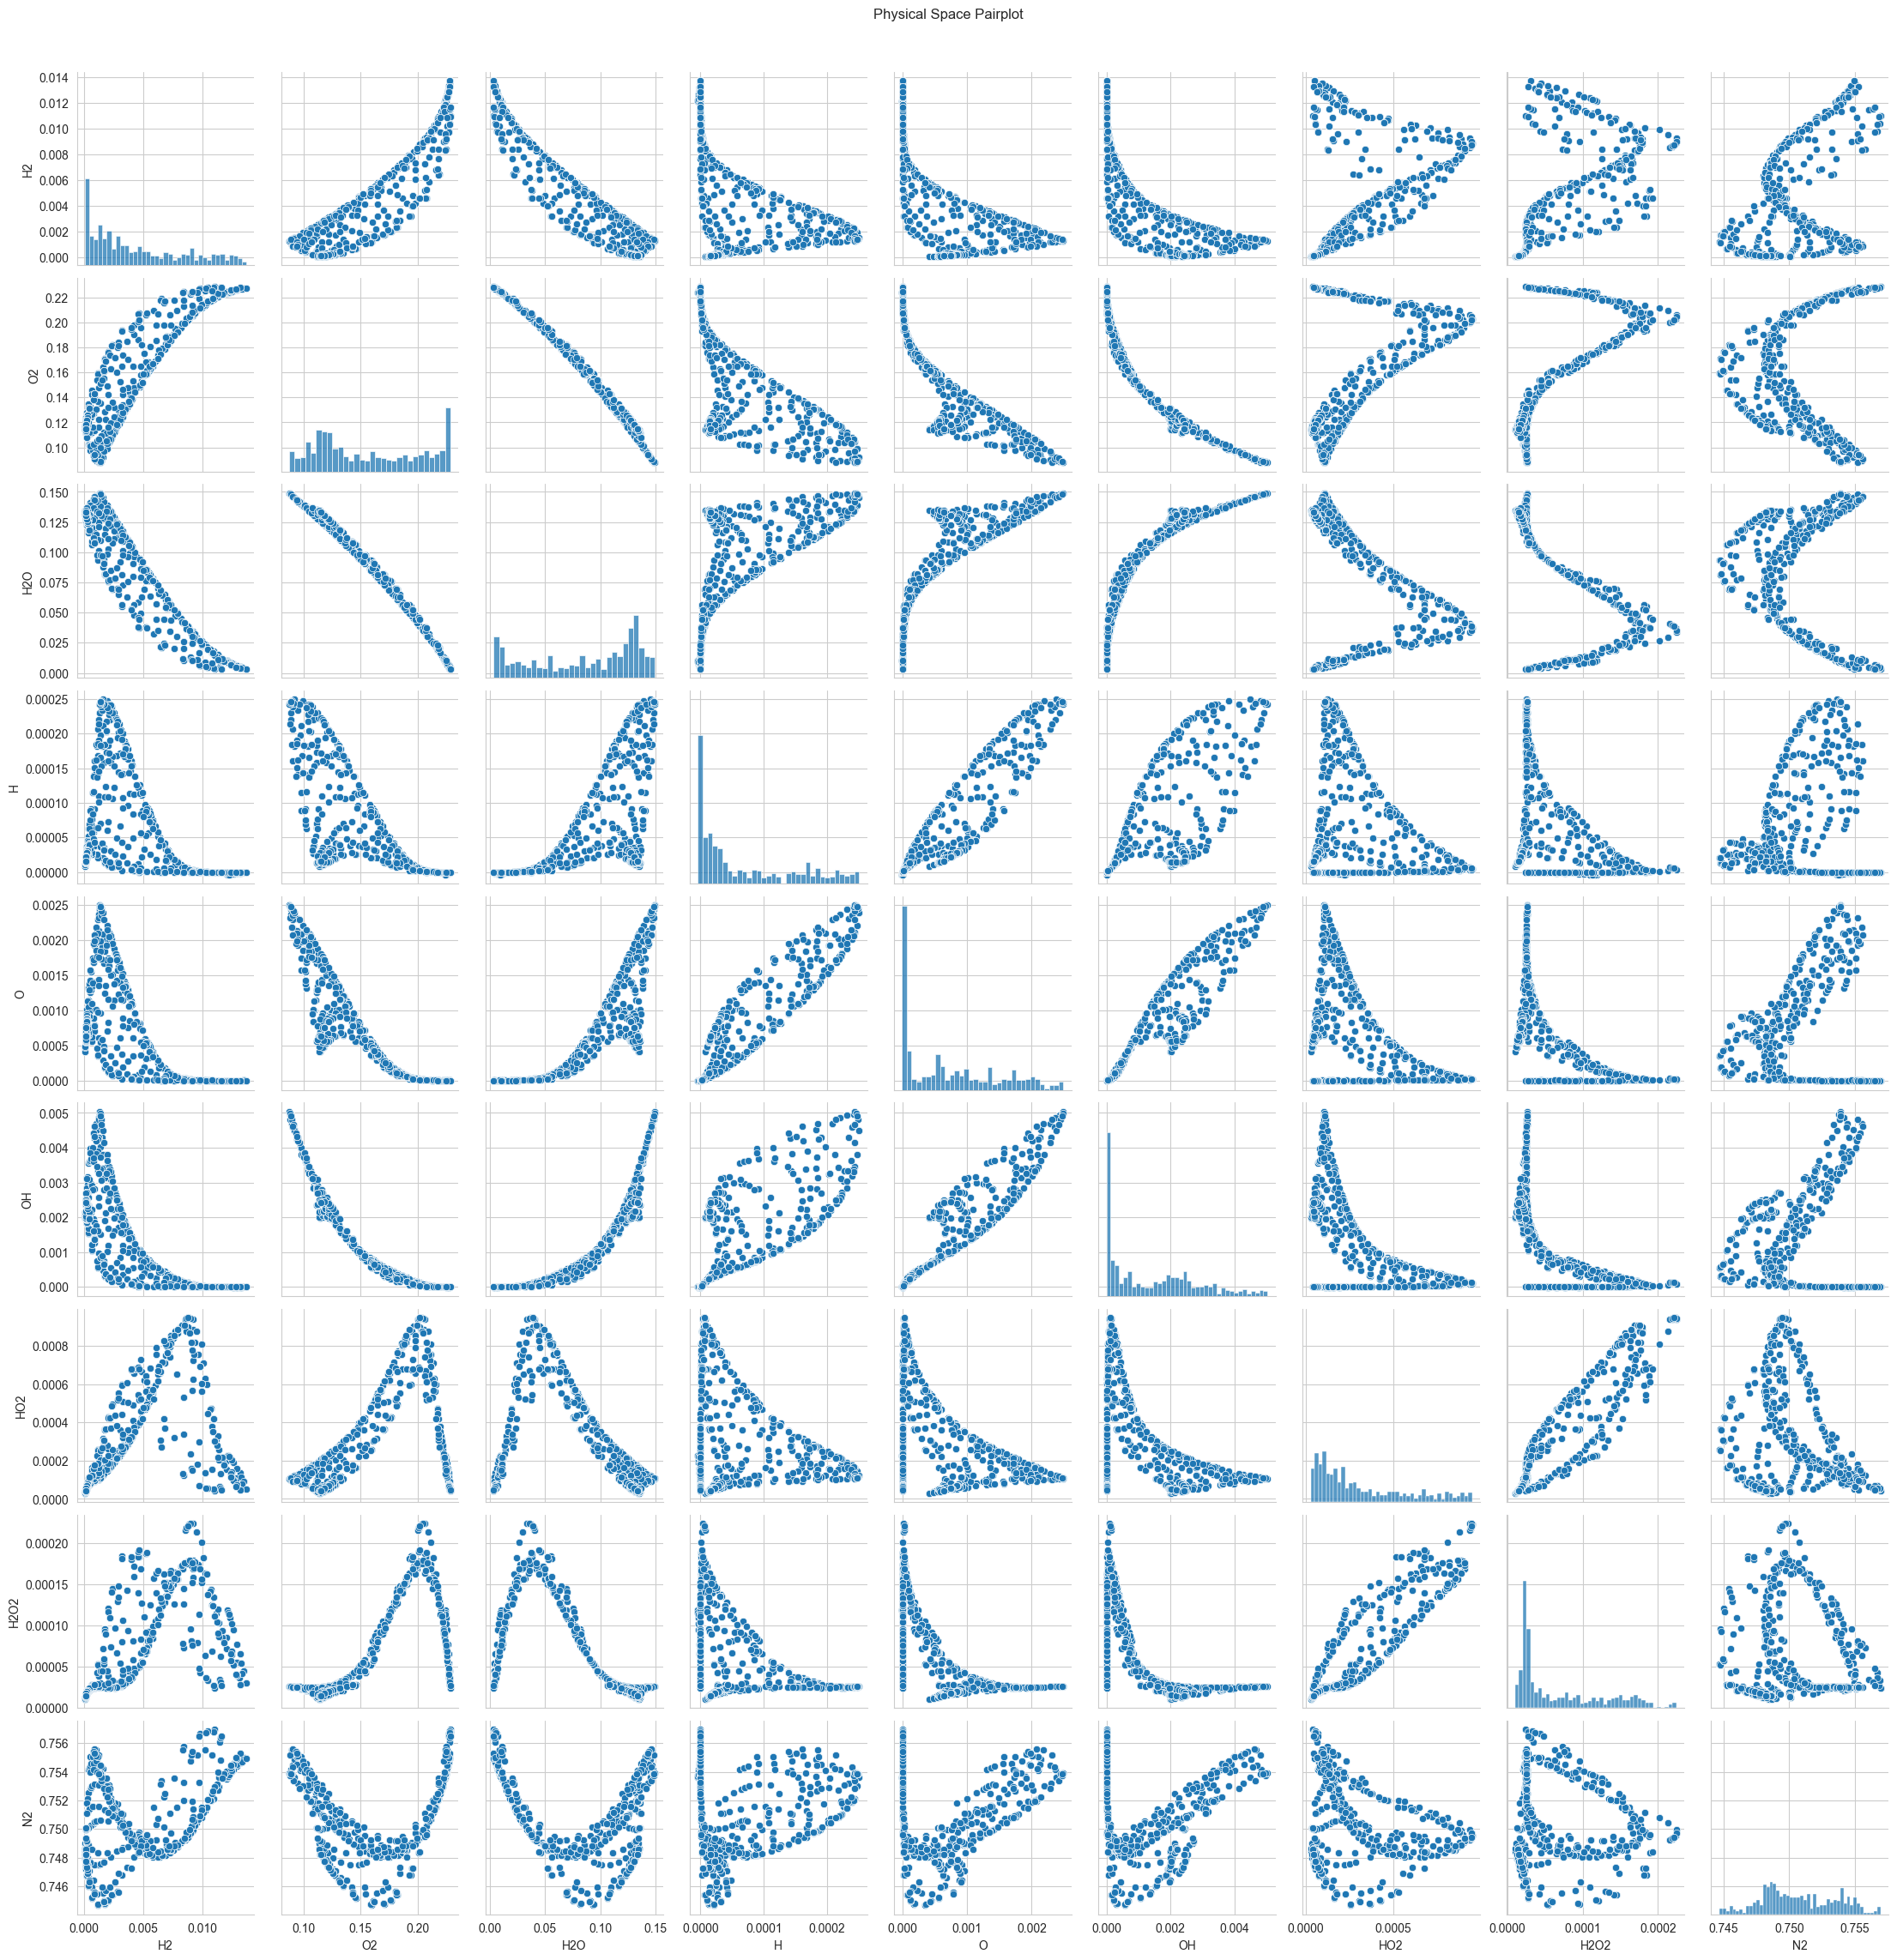

In [27]:
sns.pairplot(df[features])
plt.suptitle('Physical Space Pairplot', y=1.02)
plt.show()

## UMAP

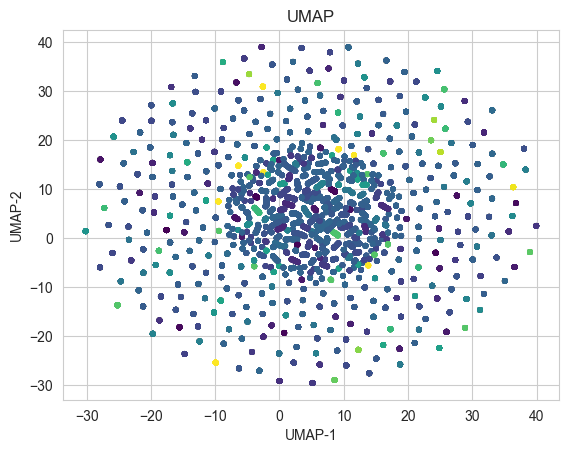

In [31]:
# UMAP embedding
reducer = umap.UMAP(n_neighbors=100, n_components=2 ,init ="random")
X_embedded = reducer.fit_transform(X)
# Plot
plt.scatter(X_embedded[:,0], X_embedded[:,1],c=colourmap, cmap='viridis', s=10)
plt.title("UMAP")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.show()

## UMAP -> HDBSCAN -> MI -> Mapping to original space
Taken from "Identifying key features in reactive flows: A tutorial on combining
dimensionality reduction, unsupervised clustering, and feature correlation"

C:\Users\alexp\Documents\Bachelor Thesis\Code\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\alexp\Documents\Bachelor Thesis\Code\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Cluster summary: {np.int64(-1): np.int64(17969), np.int64(0): np.int64(320), np.int64(1): np.int64(240), np.int64(2): np.int64(323), np.int64(3): np.int64(323), np.int64(4): np.int64(237), np.int64(5): np.int64(241), np.int64(6): np.int64(400), np.int64(7): np.int64(481), np.int64(8): np.int64(1203), np.int64(9): np.int64(481), np.int64(10): np.int64(320), np.int64(11): np.int64(401), np.int64(12): np.int64(320), np.int64(13): np.int64(559), np.int64(14): np.int64(244), np.int64(15): np.int64(320), np.int64(16): np.int64(320), np.int64(17): np.int64(320), np.int64(18): np.int64(16338)}
Number of clusters (excluding noise): 19
Noise fraction: 0.43445357833655707
Average cluster probability: 0.9245910774030687


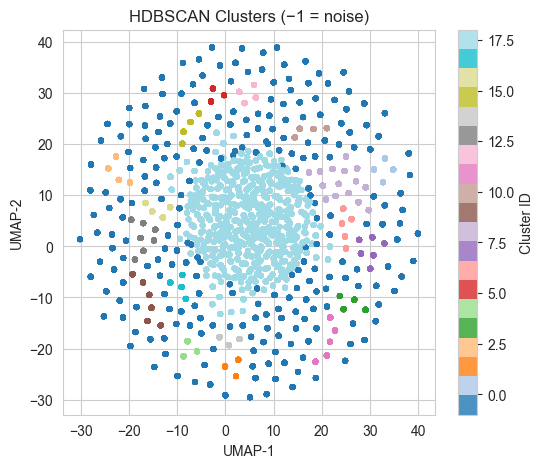

In [32]:
# ============================================================
# HDBSCAN CLUSTERING
# ============================================================
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=int(np.sqrt(len(X))),
    min_samples=int(np.sqrt(len(X))),
    metric='euclidean',
    cluster_selection_method='eom',
    prediction_data=True
).fit(X_embedded)

labels = clusterer.labels_
proba  = clusterer.probabilities_
outlier_scores = clusterer.outlier_scores_

unique, counts = np.unique(labels, return_counts=True)
cluster_summary = dict(zip(unique, counts))
print("Cluster summary:", cluster_summary)
print("Number of clusters (excluding noise):", len(set(labels)) - (1 if -1 in labels else 0))
print("Noise fraction:", np.mean(labels == -1))
print("Average cluster probability:", proba[labels != -1].mean() if np.any(labels != -1) else 0)

# ============================================================
# UMAP SPACE PLOT
# ============================================================
plt.figure(figsize=(6,5))
scatter = plt.scatter(
    X_embedded[:,0], X_embedded[:,1],
    c=labels, cmap='tab20', s=10, alpha=0.8
)
plt.title("HDBSCAN Clusters (−1 = noise)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.colorbar(scatter, label="Cluster ID")
plt.show()


Global mutual information ranking:
  feature   MI_dim1   MI_dim2     MI_sum
8      N2  5.626996  5.664811  11.291807
6     HO2  5.609653  5.645895  11.255548
2     H2O  5.603293  5.639028  11.242321
0      H2  5.599485  5.638276  11.237761
1      O2  5.591498  5.628689  11.220187
7    H2O2  5.568533  5.606700  11.175233
3       H  5.535125  5.572863  11.107988
5      OH  5.518954  5.558026  11.076979
4       O  5.493038  5.536012  11.029049


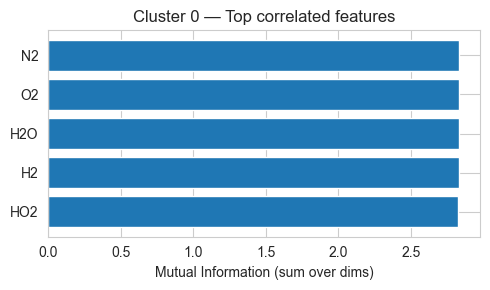

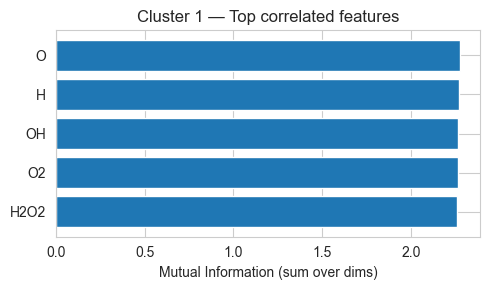

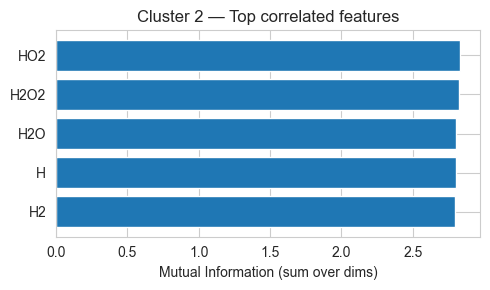

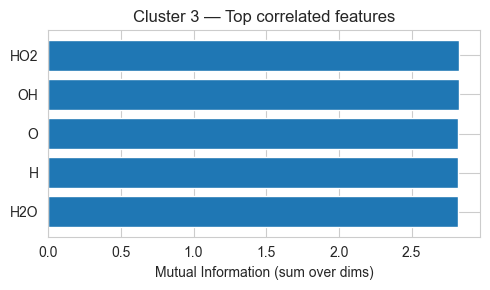

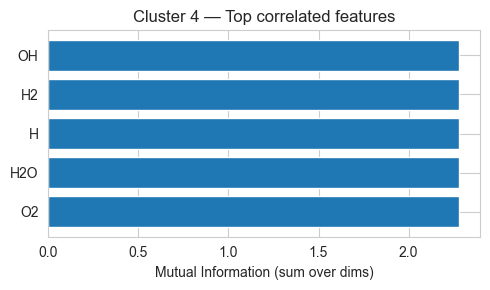

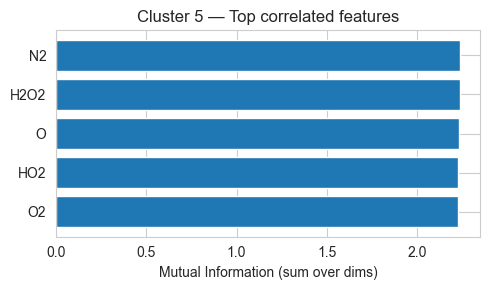

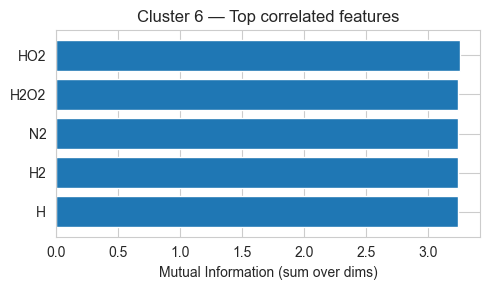

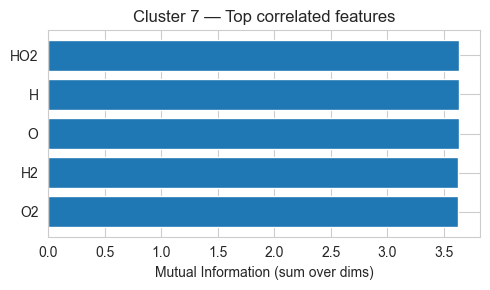

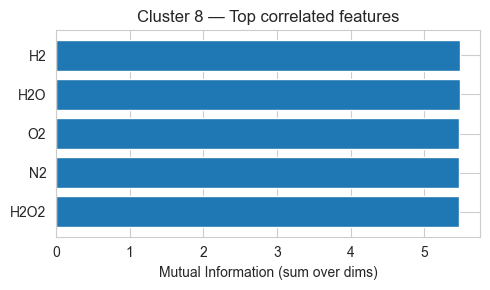

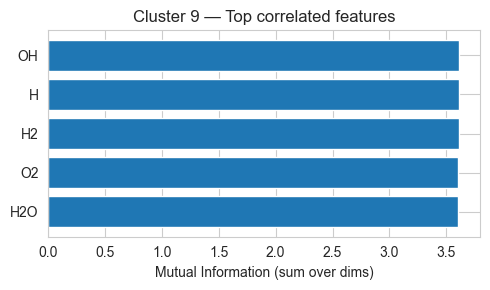

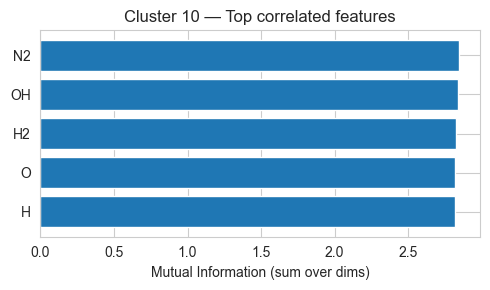

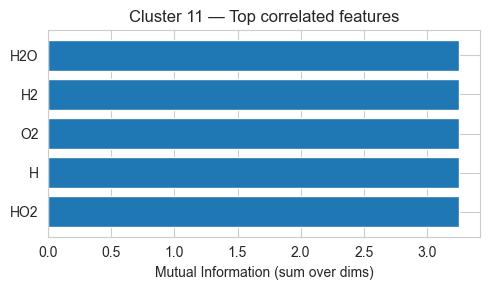

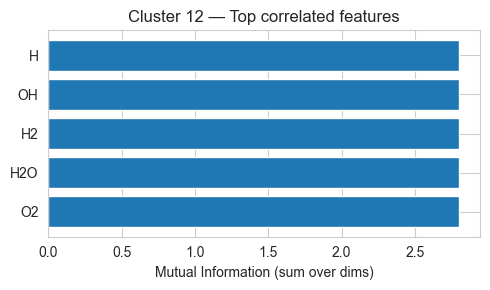

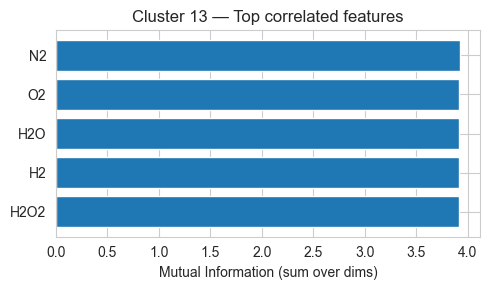

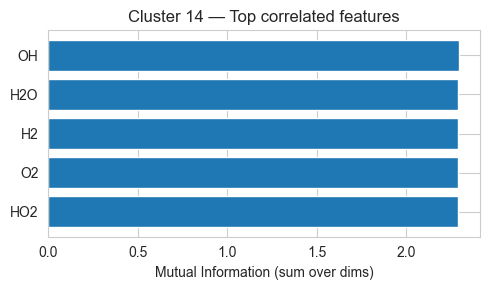

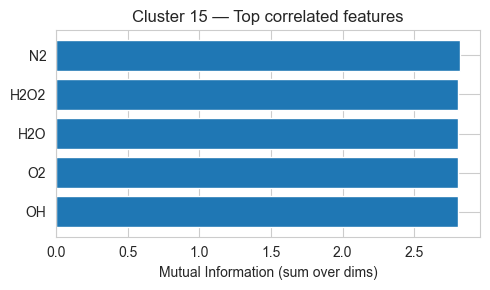

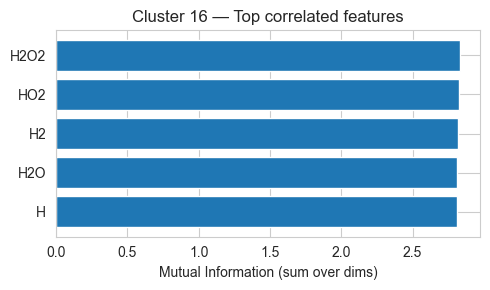

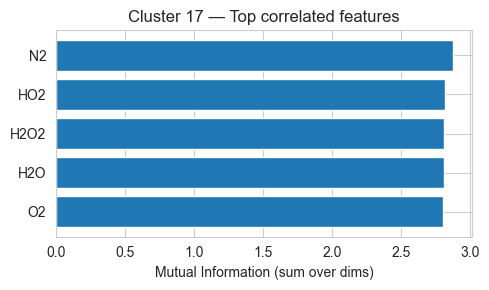

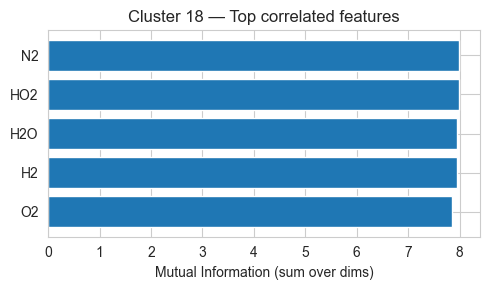

In [33]:

# ============================================================
# GLOBAL MUTUAL INFORMATION
# ============================================================
from sklearn.feature_selection import mutual_info_regression

mi_x1 = mutual_info_regression(X, X_embedded[:, 0], random_state=0)
mi_x2 = mutual_info_regression(X, X_embedded[:, 1], random_state=0)

df_mi_global = pd.DataFrame({
    'feature': features,
    'MI_dim1': mi_x1,
    'MI_dim2': mi_x2,
    'MI_sum':  mi_x1 + mi_x2
}).sort_values('MI_sum', ascending=False)

print("Global mutual information ranking:")
print(df_mi_global.head(10))
# ============================================================
# PER-CLUSTER MUTUAL INFORMATION
# ============================================================
cluster_labels = sorted(set(labels) - {-1})
mi_cluster = {}

for cluster in cluster_labels:
    mask = labels == cluster
    if mask.sum() < 10:
        continue

    mi1 = mutual_info_regression(X[mask], X_embedded[mask, 0], random_state=0)
    mi2 = mutual_info_regression(X[mask], X_embedded[mask, 1], random_state=0)

    df_new = pd.DataFrame({
        'feature': features,
        'MI_dim1': mi1,
        'MI_dim2': mi2,
        'MI_sum':  mi1 + mi2
    }).sort_values('MI_sum', ascending=False)

    mi_cluster[cluster] = df_new


# Plot top correlations
for cluster, df_new in mi_cluster.items():
    top = df_new.head(5)
    plt.figure(figsize=(5,3))
    plt.barh(top['feature'][::-1], top['MI_sum'][::-1])
    plt.xlabel("Mutual Information (sum over dims)")
    plt.title(f"Cluster {cluster} — Top correlated features")
    plt.tight_layout()
    plt.show()



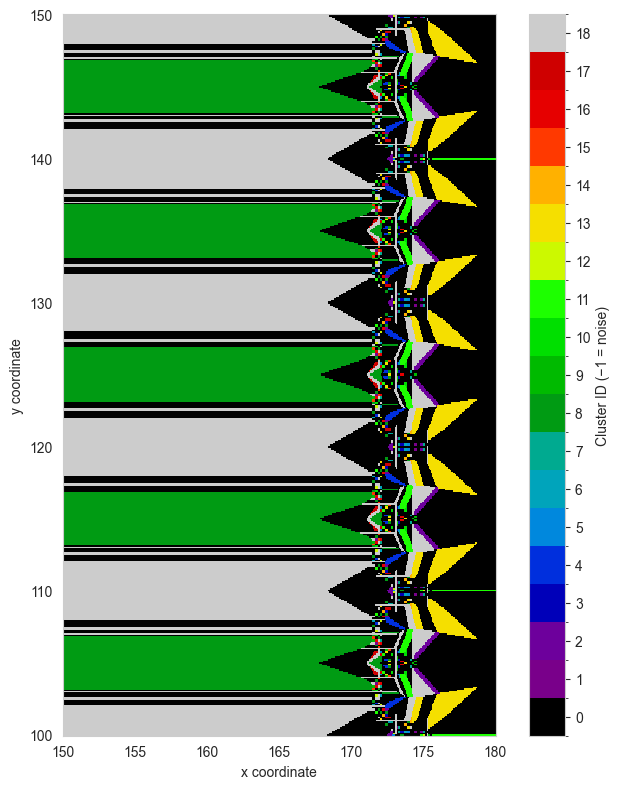

               H2        O2       H2O         H         O        OH       HO2  \
cluster                                                                         
-1       0.004094  0.155209  0.087666  0.000062  0.000710  0.001464  0.000296   
 0       0.007045  0.170013  0.066833  0.000097  0.000883  0.001585  0.000174   
 1       0.004697  0.173801  0.072285  0.000025  0.000233  0.000459  0.000572   
 2       0.003355  0.141762  0.100311  0.000070  0.000936  0.002167  0.000085   
 3       0.003255  0.154639  0.088901  0.000082  0.000821  0.001396  0.000341   

             H2O2        N2  
cluster                      
-1       0.000067  0.750431  
 0       0.000045  0.753325  
 1       0.000103  0.747825  
 2       0.000024  0.751291  
 3       0.000078  0.750487  


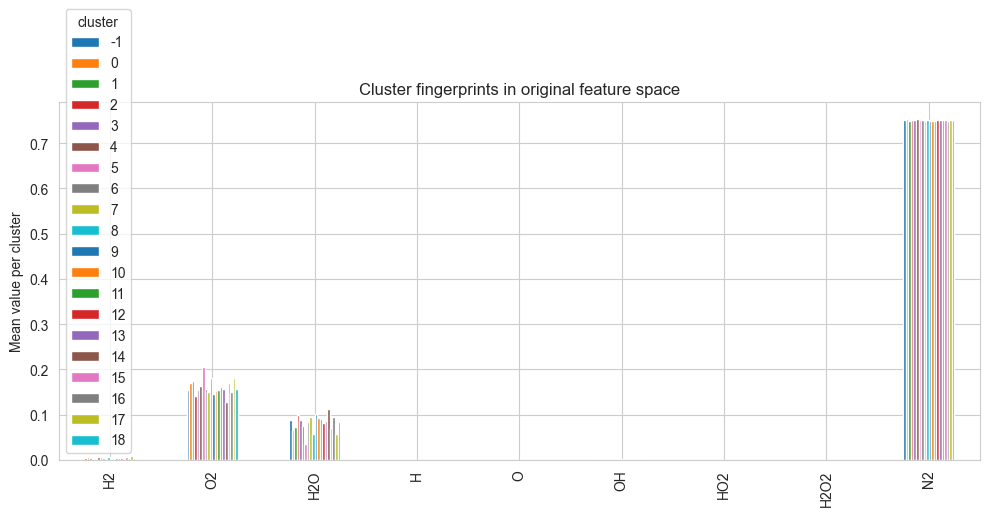

In [34]:
import numpy as np

# Define resolution
nx, ny = 500, 500   # increase for higher smoothness

x_min, x_max = 150, 180
y_min, y_max = 100, 150

grid_x, grid_y = np.meshgrid(
    np.linspace(x_min, x_max, nx),
    np.linspace(y_min, y_max, ny)
)
from scipy.interpolate import griddata

z_structured = griddata(
    (df['x'], df['y']),
    labels,
    (grid_x, grid_y),
    method='nearest'     # CRITICAL for categorical data
)

import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
import matplotlib

bounds = np.arange(-0.5, labels.max()+1.5, 1)
cmap = matplotlib.colormaps['nipy_spectral']
norm = BoundaryNorm(bounds, cmap.N)

plt.figure(figsize=(7,8))

plt.pcolormesh(
    grid_x, grid_y, z_structured,
    cmap=cmap,
    norm=norm,
    shading='nearest'  # correct for categorical
)

cb = plt.colorbar(ticks=np.arange(labels.min(), labels.max()+1))
cb.set_label("Cluster ID (−1 = noise)")

plt.xlabel("x coordinate")
plt.ylabel("y coordinate")
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.show()


# ============================================================
# STATISTICS + FINGERPRINTS
# ============================================================
df_with_labels = df.copy()
df_with_labels["cluster"] = labels

cluster_means = df_with_labels.groupby("cluster")[features].mean()
cluster_stds  = df_with_labels.groupby("cluster")[features].std()

print(cluster_means.head())

cluster_means.T.plot(kind='bar', figsize=(10,5))
plt.ylabel("Mean value per cluster")
plt.title("Cluster fingerprints in original feature space")
plt.tight_layout()
plt.show()


## Spectral Embedding

C:\Users\alexp\Documents\Bachelor Thesis\Code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


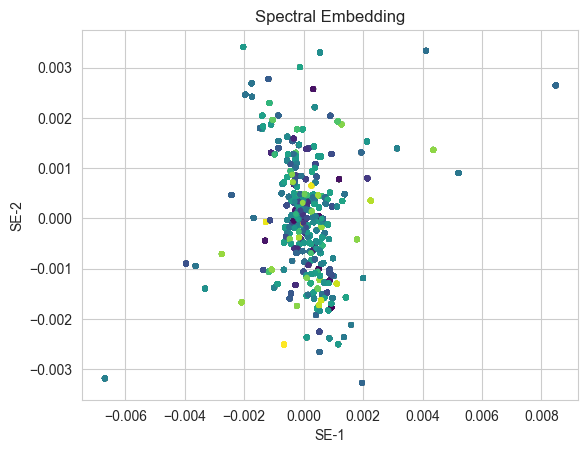

In [10]:
SE = SpectralEmbedding(n_components=2, n_neighbors=30)
X_SE = SE.fit_transform(X)
# Plot
plt.scatter(X_SE[:,0], X_SE[:,1],c=colourmap, cmap='viridis', s=10)
plt.title("Spectral Embedding")
plt.xlabel("SE-1")
plt.ylabel("SE-2")
plt.show()

## t-SNE

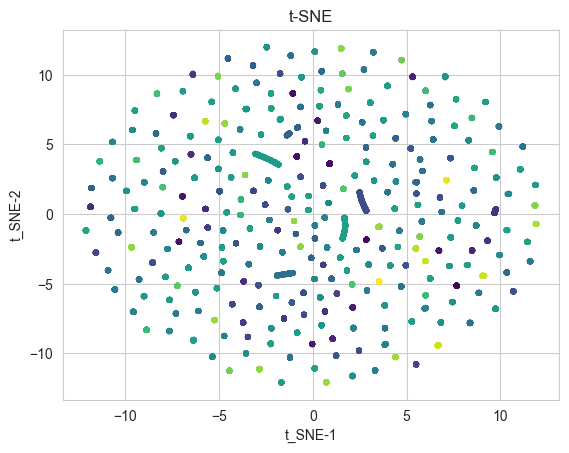

In [9]:
t_sne = TSNE(
    n_components=2,
    perplexity=30,
    init="random",
    max_iter=250,
    random_state=0,
)
X_sne = t_sne.fit_transform(X)

plt.scatter(X_sne[:,0], X_sne[:,1],c=colourmap, cmap='viridis', s=10)
plt.title("t-SNE")
plt.xlabel("t_SNE-1")
plt.ylabel("t_SNE-2")
plt.show()


## Multidimensional Scaling

In [30]:
mds_embedding = MDS(n_components=2, n_init=1)
X_mds = mds_embedding.fit_transform(X)

plt.scatter(X_mds[:,0], X_mds[:,1],c=colourmap, cmap='viridis', s=10)
plt.title("MDS")
plt.xlabel("MDS-1")
plt.ylabel("MDS-2")
plt.show()


KeyboardInterrupt: 

[State-space features (φ)] Centroids in original feature units:
 [[3.26800270e-04 1.18387747e-01 1.28639098e-01 3.38058722e-05
  8.26813164e-04 2.38523488e-03 7.63277262e-05 1.86599486e-05]
 [3.06049110e-03 1.27788832e-01 1.14767951e-01 1.69675848e-04
  1.36844457e-03 1.92910677e-03 2.54706499e-04 3.00491841e-05]
 [1.37055213e-03 9.87842078e-02 1.39633373e-01 1.85096868e-04
  2.00644427e-03 3.94199853e-03 1.24245104e-04 2.46306005e-05]
 [1.97299729e-03 1.63302677e-01 8.68482578e-02 2.90149014e-05
  3.55742352e-04 5.60752799e-04 3.48311542e-04 7.49445191e-05]
 [4.98246841e-03 1.58678985e-01 8.56228181e-02 8.77584550e-05
  5.50825332e-04 7.92066095e-04 4.75178692e-04 7.14437280e-05]]

[State-space features (φ)] Explained variance ratio per component:
  PC 1:  0.6884   (cumulative:  0.6884)
  PC 2:  0.2534   (cumulative:  0.9418)
  PC 3:  0.0405   (cumulative:  0.9823)
  PC 4:  0.0140   (cumulative:  0.9963)
  PC 5:  0.0030   (cumulative:  0.9993)
  PC 6:  0.0005   (cumulative:  0.9998)
 

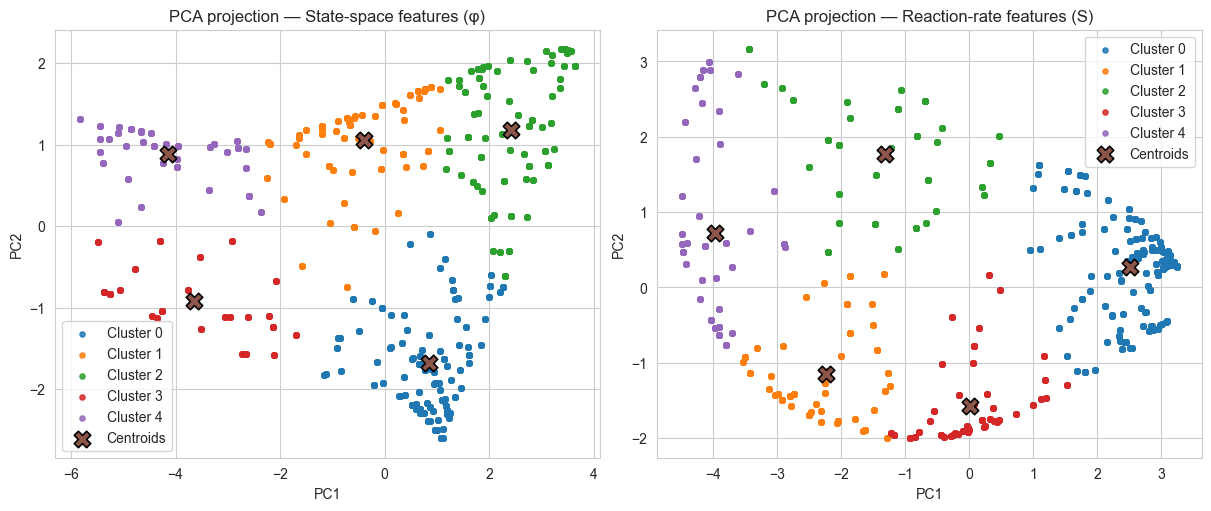

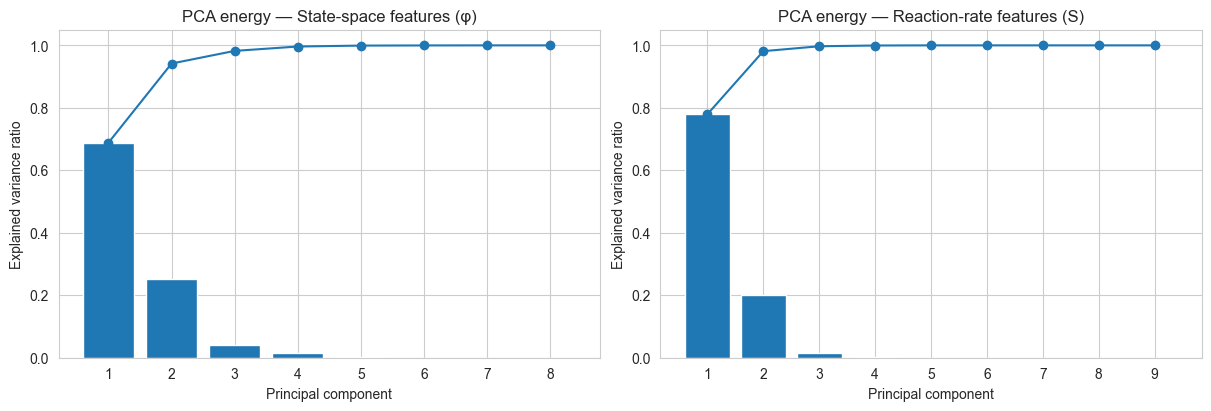

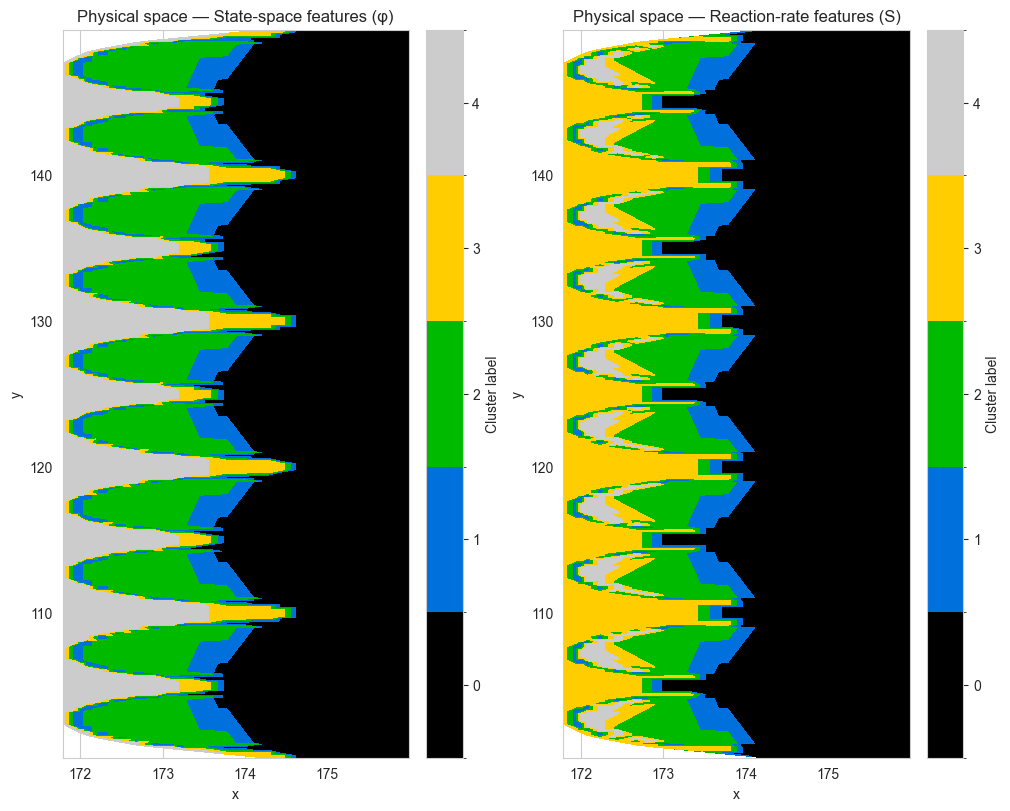

In [54]:
from sklearn.decomposition import PCA
# --- Pre-create side-by-side figures (left=state features, right=rate features) ---
fig_pca,   axs_pca   = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)
fig_scree, axs_scree = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)
fig_phys,  axs_phys  = plt.subplots(1, 2, figsize=(10, 8), constrained_layout=True)

col_titles = {0: "State-space features (φ)", 1: "Reaction-rate features (S)"}

import matplotlib.tri as mtri
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib as mat

# Triangulation of fixed physical coordinates (reuse for both feature settings)
tri = mtri.Triangulation(df['x'].to_numpy(), df['y'].to_numpy())

for feature_setting in range(2):
    if feature_setting == 0:
        features = [
            'H2', 'O2', 'H2O', 'H', 'O', 'OH', 'HO2', 'H2O2'
        ]
    else:
        features = [
            'omega_H2', 'omega_O2', 'omega_H2O', 'omega_H', 'omega_O', 'omega_OH',
            'omega_HO2', 'omega_H2O2', 'omega_N2'
        ]

    X_raw = df[features].to_numpy()
    k = 5
    pipe = make_pipeline(
        StandardScaler(with_mean=True, with_std=True),
        KMeans(n_clusters=k, init="k-means++", n_init="auto", max_iter=300, random_state=0)
    )
    labels = pipe.fit_predict(X_raw)

    # Pull out scaler and centroids (centroids are in scaled space)
    scaler = pipe.named_steps["standardscaler"]
    centroids_scaled   = pipe.named_steps["kmeans"].cluster_centers_
    centroids_unscaled = scaler.inverse_transform(centroids_scaled)
    print(f"[{col_titles[feature_setting]}] Centroids in original feature units:\n", centroids_unscaled)

    # Optional: quality metric
    X_scaled = scaler.transform(X_raw)

    # ===== PCA for visualization (fit on scaled data seen by KMeans) =====
    pca = PCA(n_components=None, random_state=0)
    X2d        = pca.fit_transform(X_scaled)            # (n, >=2)
    centroids2d = pca.transform(centroids_scaled)       # centroids in scaled space

    evr     = pca.explained_variance_ratio_
    cum_evr = np.cumsum(evr)
    print(f"\n[{col_titles[feature_setting]}] Explained variance ratio per component:")
    for i, (e, c) in enumerate(zip(evr, cum_evr), start=1):
        print(f"  PC{i:>2}: {e:7.4f}   (cumulative: {c:7.4f})")

    # ===== Plot A: PCA clusters (side-by-side) =====
    axp = axs_pca[feature_setting]
    for c in range(k):
        axp.scatter(
            X2d[labels == c, 0], X2d[labels == c, 1],
            s=14, alpha=0.85, label=f"Cluster {c}"
        )
    axp.scatter(
        centroids2d[:, 0], centroids2d[:, 1],
        s=140, marker="X", edgecolor="k", linewidths=1.2, label="Centroids"
    )
    axp.set_title(f"PCA projection — {col_titles[feature_setting]}")
    axp.set_xlabel("PC1")
    axp.set_ylabel("PC2")
    axp.legend(loc="best")

    # ===== Plot B: Scree (side-by-side) =====
    axs = axs_scree[feature_setting]
    idx = np.arange(1, len(evr) + 1)
    axs.bar(idx, evr)
    axs.plot(idx, cum_evr, marker="o")
    axs.set_title(f"PCA energy — {col_titles[feature_setting]}")
    axs.set_xlabel("Principal component")
    axs.set_ylabel("Explained variance ratio")
    axs.set_xticks(idx)

    # ===== Plot C: Physical x–y map (side-by-side) — continuous categorical fill =====
    # --- choose a categorical colormap with exactly k distinct colors ---
    cmap = mat.colormaps.get_cmap('nipy_spectral')
    # --- discrete boundaries so each integer label maps to one color band ---
    bounds = np.arange(-0.5, k + 0.5, 1)
    norm   = BoundaryNorm(bounds, cmap.N)

    z = labels  # cluster labels (length n)

    # >>>>> THIS IS THE IMPORTANT CHANGE <<<<<
    ax_phys = axs_phys[feature_setting]  # use pre-created axis instead of new figure

    # Option 1: use triangulation (slightly cleaner)
    c = ax_phys.tricontourf(tri, z, levels=bounds, cmap=cmap, norm=norm)

    # Attach colorbar to fig_phys, but only for this axis
    cb = fig_phys.colorbar(c, ax=ax_phys, ticks=np.arange(k))
    cb.set_label("Cluster label")

    ax_phys.set_xlabel("x")
    ax_phys.set_ylabel("y")

    ax_phys.set_title(f"Physical space — {col_titles[feature_setting]}")

# --- Render all figures once, side-by-side comparisons ready ---
plt.show()


In [ ]:
fri